In [1]:
from tf_unet_modified import unet
from tf_unet_modified.Trainer import Trainer
from tf_unet_modified.Trainer import error_rate
import tensorflow as tf
from BatchGeneration import Batch
from DataPreparation import DataPreparation
from utils import *
import os
import tables
import numpy as np
from copy import deepcopy
import cv2
import time
import matplotlib.pyplot as plt

IMPORT DATA

In [ ]:
#input_videos_dir = "data/Tracking_Robotic_Training/Training/"
#input_labels_dir = "data/EndoVisPoseAnnotation-master/train_labels"
#output_dir = "data/Tracking_Robotic_Training/Training_set/"
#output_file_name = "train_images_128.hdf5"

In [ ]:
#dp = DataPreparation(input_videos_dir,input_labels_dir, output_dir)
#print("------------------Preparing Data--------------------- ")
#dp.extractFrames(output_file_name)

In [2]:

#To check training set
trainhdf5filename = "data/Tracking_Robotic_Training/Training_set/train_images_224.hdf5"
testhdf5filename = "data/Test_set/test_images_224.hdf5"
"""
# Train image show
trainhdf5file = os.path.abspath(trainhdf5filename)
trainhdf5file = tables.open_file(trainhdf5file, "r")
X = trainhdf5file.root.images
labs = trainhdf5file.root.rawlabels
"""



'\n# Train image show\ntrainhdf5file = os.path.abspath(trainhdf5filename)\ntrainhdf5file = tables.open_file(trainhdf5file, "r")\nX = trainhdf5file.root.images\nlabs = trainhdf5file.root.rawlabels\n'

Class declaration for handling the u-net training, 

In [3]:
class BatchGenerator:
    def __init__(self, train_images, train_classi_labels, train_locali_labels, test_images, test_classi_labels,
                 test_locali_labels):
        self._timages = train_images
        self._tclabels = train_classi_labels
        self._tllabels = train_locali_labels
        self._testimages = test_images
        self._testclabels = test_classi_labels
        self._testllabels = test_locali_labels

        self.train_offset = 0
        self.val_offset = 0
        self.test_offset= 0
        
        self.tr_size = self._timages.shape[0]
        self.test_size = self._testimages.shape[0]
        self.val_size = int(np.floor(self.test_size * 0.3)) # Use 30% of test set as validation
        
        self.indices_train = np.arange(self.tr_size)
        self.indices_test = np.arange(self.test_size)

        np.random.shuffle(self.indices_train)
        np.random.shuffle(self.indices_test)
        
        self.indices_val = self.indices_test[0:self.val_size]
        self.indices_test = self.indices_test[self.val_size:]
        self.test_size = len(self.indices_test)

    def get_next_training_batch(self, batch_size):
        images = []
        clabels = []
        llabels = []
        if len(self.indices_train) >= batch_size:
            images = self._timages[self.indices_train[0:batch_size],:]
            clabels = self._tclabels[self.indices_train[0:batch_size],:]
            llabels = self._tllabels[self.indices_train[0:batch_size],:]
            self.indices_train = self.indices_train[batch_size:]
        else:
            images = self._timages[self.indices_train[0:],:]
            clabels = self._tclabels[self.indices_train[0:],:]
            llabels = self._tllabels[self.indices_train[0:],:]
            self.indices_train = []
            
        if len(self.indices_train) == 0:
            print("Training epoch happening after this return")
            # An epoch happened on val data
            # shuffle VALIDATION data indices
            self.indices_train = np.arange(self.tr_size)
            np.random.shuffle(self.indices_train)
        return images, clabels, llabels
    
    def get_next_validation_batch(self, batch_size):
        images = []
        clabels = []
        tlabels = []
        if (self.val_offset + batch_size) <= len(self.indices_val):
            images = self._testimages[self.indices_val[0:batch_size], :]
            clabels = self._testclabels[self.indices_val[0:batch_size], :]
            llabels = self._testllabels[self.indices_val[0:batch_size], :]
            self.val_offset += batch_size
        else:
            images = self._testimages[self.indices_val[0:],:]
            clabels = self._testclabels[self.indices_val[0:],:]
            llabels = self._testllabels[self.indices_val[0:],:]
            self.val_offset += batch_size
            
        if self.val_offset >= len(self.indices_val):
            print("Validation epoch happening after this return")
            # An epoch happened on val data
            # shuffle VALIDATION data indices
            np.random.shuffle(self.indices_val)
            self.val_offset = 0
        return images, clabels, llabels
    
    def get_next_test_batch(self, batch_size):
        images = []
        clabels = []
        tlabels = []
        if (self.test_offset + batch_size) <= len(self.indices_test):
            images = self._testimages[self.indices_test[0:batch_size], :]
            clabels = self._testclabels[self.indices_test[0:batch_size], :]
            llabels = self._testllabels[self.indices_test[0:batch_size], :]
            self.test_offset += batch_size
        else:
            images = self._testimages[self.indices_test[0:],:]
            clabels = self._testclabels[self.indices_test[0:],:]
            llabels = self._Testllabels[self.indices_test[0:],:]
            self.test_offset += batch_size
            
        if self.test_offset >= len(self.indices_test):
            print("Test epoch happening after this return")
            # An epoch happened on test data
            # shuffle TEST data indices
            np.random.shuffle(self.indices_test)
            self.test_offset = 0
        return images, clabels, llabels
    


In [4]:
class DataProvider:
    """
    Class which provides data related functions
    """

    def __init__(self, trainhdf5file, testhdf5file):
        trainhdf5file = os.path.abspath(trainhdf5file)
        testhdf5file = os.path.abspath(testhdf5file)

        trainhdf5file = tables.open_file(trainhdf5file, "r")
        testhdf5file = tables.open_file(testhdf5file, "r")
        print(trainhdf5file)
        print(testhdf5file)
        
        self.train_X = trainhdf5file.root.images
        self.train_classi_Y = trainhdf5file.root.classilabels
        self.train_locali_Y = trainhdf5file.root.localilabels
        
        self.test_X = testhdf5file.root.images
        self.test_classi_Y = testhdf5file.root.classilabels
        self.test_locali_Y = testhdf5file.root.localilabels
    
        # To make everything fast at the expense of huge RAM usage, pass these handlers as numpy arrays 
        # to BatchGenerator
        self.batch_handler = BatchGenerator(self.train_X, self.train_classi_Y, self.train_locali_Y,
                                            self.test_X, self.test_classi_Y, self.test_locali_Y)

    def get_training_batch(self, n):
        return self.batch_handler.get_next_training_batch(n)
    
    def no_validation_batches(self, batch_size):
        if len(self.batch_handler.indices_validation)%batch_size == 0:
            return len(self.batch_handler.indices_validation)/batch_size
        else:
            return len(self.batch_handler.indices_validation)/batch_size + 1
        
    def get_validation_batch(self, n):
        return self.batch_handler.get_next_validation_batch(n)

In [ ]:
    
train_input_videos_dir = "data/Tracking_Robotic_Training/Training"
train_input_labels_dir = "data/EndoVisPoseAnnotation-master/train_labels"
train_output_dir = "data/Tracking_Robotic_Training/Training_set/"
train_output_file_name = "train_images_2.hdf5"

test_input_videos_dir = "data/Tracking"
test_input_labels_dir = "data/EndoVisPoseAnnotation-master/test_labels"
test_output_dir = "data/Test_set/"
test_output_file_name = "test_images_2.hdf5"

# A. Process Training dataset
#############################################################################
##Store The images and raw labels for training and test data into hdf5 files#
#############################################################################
# For generating train images
dp = DataPreparation(train_input_videos_dir,train_input_labels_dir, train_output_dir, train_output_file_name, gen_test_imgs=False)
print("------------------Preparing Data--------------------- ")
dp.openHdfFileWrite()
dp.extractFrames()
#########################################################################################
##Now process these labels to produce classification labels and store them in hdf5 files#
#########################################################################################
dp.extractClassiLabels()
#########################################################################################
##Now process these labels to produce localization maps and store them in hdf5 files#####
#########################################################################################
dp.extractLocaliLabels()

dp.closeHdf5File()

# For generating test images
dp2 = DataPreparation(test_input_videos_dir,test_input_labels_dir, test_output_dir, test_output_file_name, gen_test_imgs=True)


print("------------------Preparing Data--------------------- ")
dp2.openHdfFileWrite()
dp2.extractFrames()
#########################################################################################
##Now process these labels to produce classification labels and store them in hdf5 files#
#########################################################################################
dp2.extractClassiLabels()
#########################################################################################
##Now process these labels to produce localization maps and store them in hdf5 files#####
#########################################################################################
dp2.extractLocaliLabels()
dp2.closeHdf5File()


Test the code below

/home/ibrar/Desktop/Machine-Learning-Medical-Imaging/MLMI-REPO/data/Tracking_Robotic_Training/Training_set/train_images_224.hdf5 (File) ''
Last modif.: 'Mon Dec 11 17:33:57 2017'
Object Tree: 
/ (RootGroup) ''
/classilabels (EArray(3760, 4)) ''
/images (EArray(3760, 224, 224, 3)) ''
/localilabels (EArray(3760, 12, 224, 224)) ''

/home/ibrar/Desktop/Machine-Learning-Medical-Imaging/MLMI-REPO/data/Test_set/test_images_224.hdf5 (File) ''
Last modif.: 'Mon Dec 11 17:34:15 2017'
Object Tree: 
/ (RootGroup) ''
/classilabels (EArray(308, 4)) ''
/images (EArray(308, 224, 224, 3)) ''
/localilabels (EArray(308, 12, 224, 224)) ''



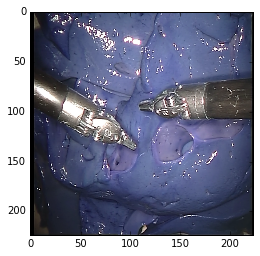

(50, 224, 224, 3)
(50, 4)
(50, 12, 224, 224)
Print train images now
[1 0 0 0]


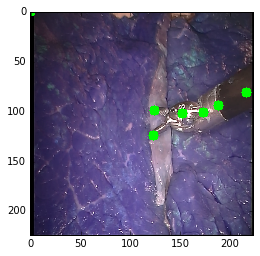

[1 0 0 0]


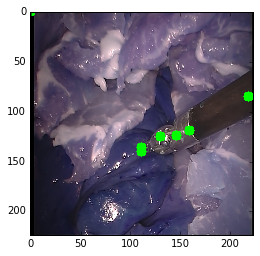

[0 1 0 0]


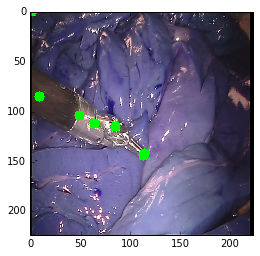

[1 1 0 0]


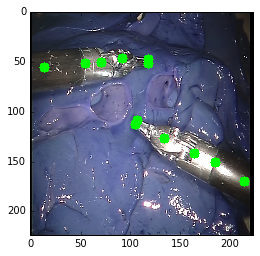

[0 1 0 0]


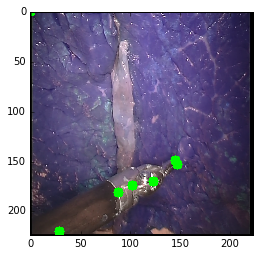

[0 1 0 0]


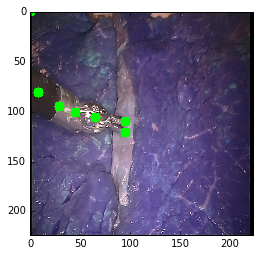

[0 1 0 0]


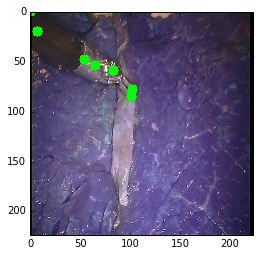

[0 1 0 0]


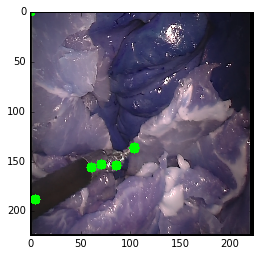

[1 0 0 0]


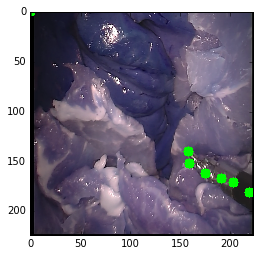

[0 1 0 0]


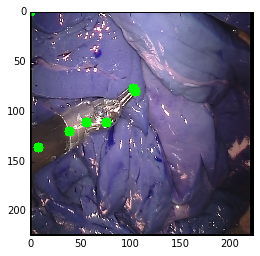

[1 1 0 0]


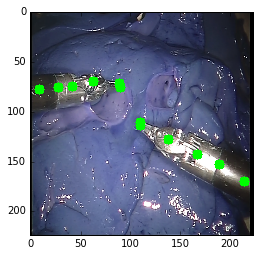

[1 0 0 0]


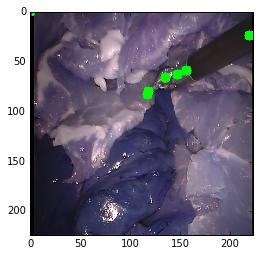

[1 0 0 0]


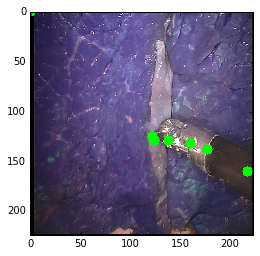

[1 0 0 0]


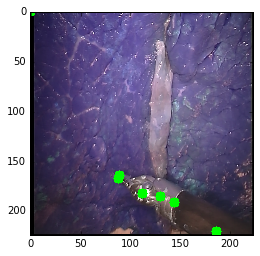

[0 1 0 0]


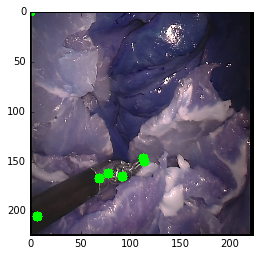

[1 0 0 0]


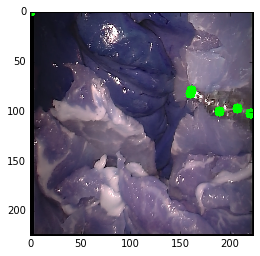

[0 1 0 0]


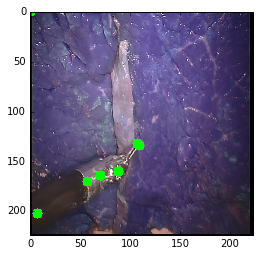

[0 1 0 0]


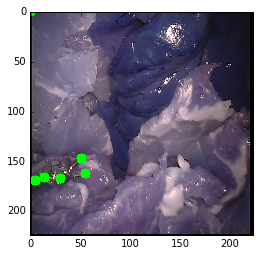

[1 0 0 0]


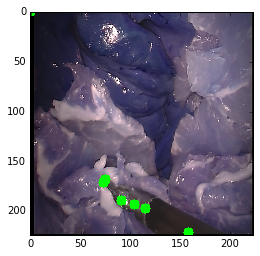

[1 1 0 0]


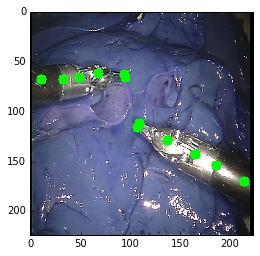

[1 1 0 0]


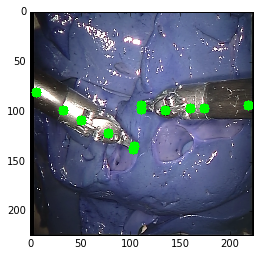

[1 0 0 0]


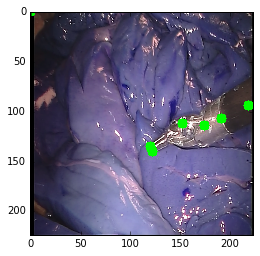

[1 0 0 0]


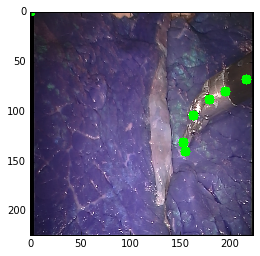

[1 0 0 0]


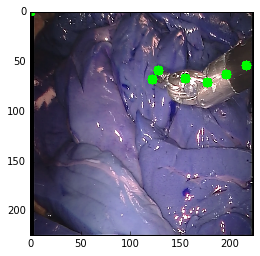

[1 0 0 0]


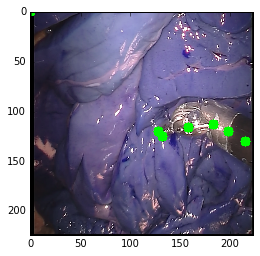

[1 0 0 0]


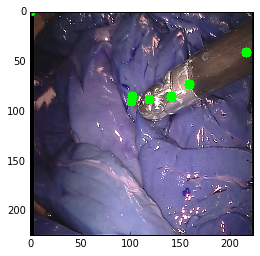

[1 1 0 0]


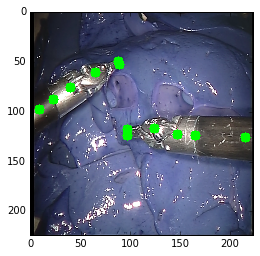

[1 0 0 0]


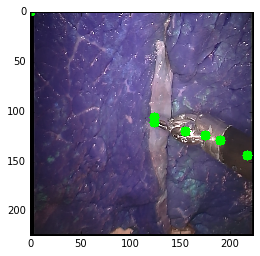

[1 1 0 0]


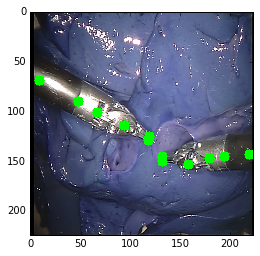

[1 0 0 0]


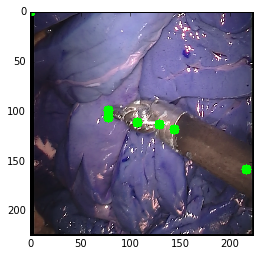

[0 1 0 0]


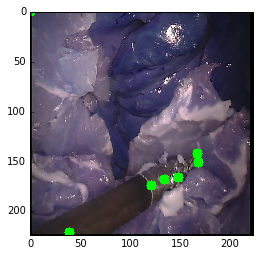

[1 1 0 0]


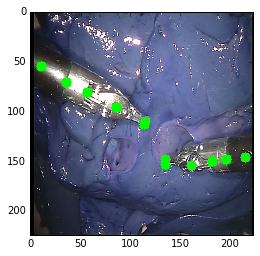

[0 1 0 0]


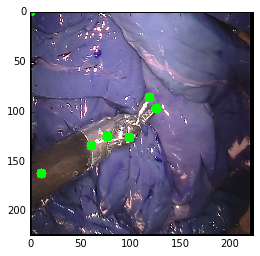

[0 1 0 0]


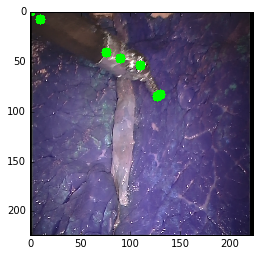

[0 1 0 0]


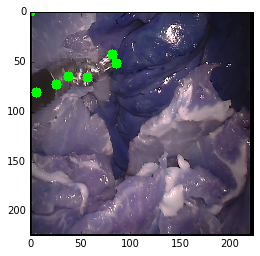

[0 1 0 0]


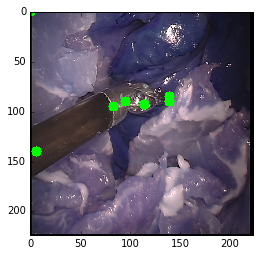

[1 1 0 0]


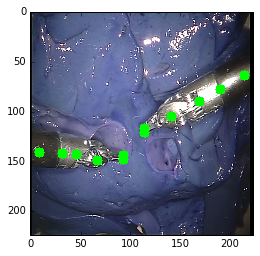

[1 0 0 0]


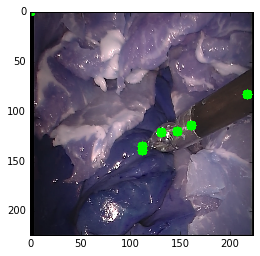

[1 0 0 0]


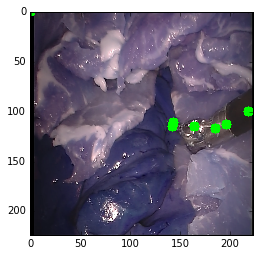

[0 1 0 0]


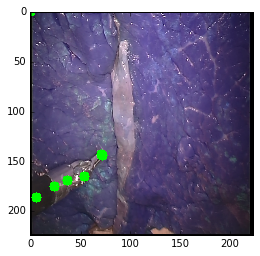

[1 0 0 0]


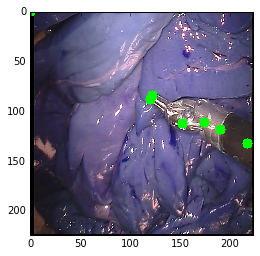

[0 1 0 0]


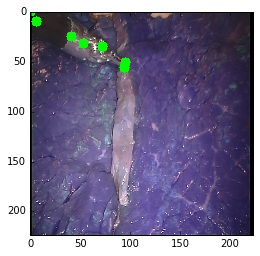

[1 0 0 0]


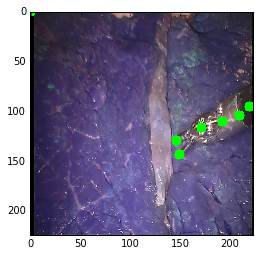

[1 1 0 0]


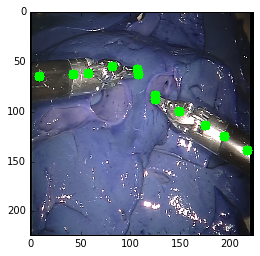

[0 1 0 0]


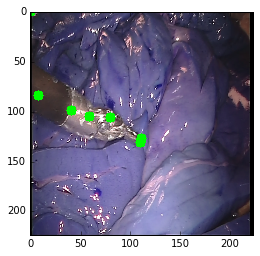

[1 0 0 0]


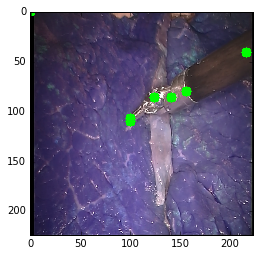

[1 0 0 0]


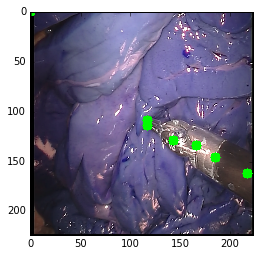

[0 1 0 0]


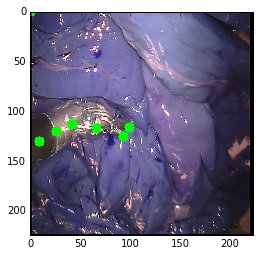

[1 0 0 0]


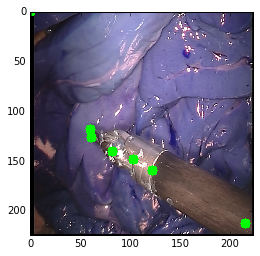

[1 1 0 0]


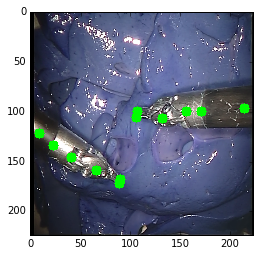

'\nprint ("Print test images now")\nprint(te_X.shape)\nprint(te_classi.shape)\nprint(te_locali.shape)\nfor i in range(te_X.shape[0]):\n    gray = te_X[i]\n    new_pmaps = te_locali[i]\n    for tool in range(new_pmaps.shape[3]):\n        for joint in range(new_pmaps.shape[2]):\n            x,y = np.unravel_index(new_pmaps[:,:,joint,tool].argmax(),[224,224])\n            cv2.circle(gray,(int(y),int(x)), 5, (0,255,0), -1)\n    print(te_classi[i])\n    plt.imshow(gray)\n    plt.show()\n'

In [5]:
# Test data preparator
data_provider = DataProvider(trainhdf5filename, testhdf5filename)
tr_X, tr_classi, tr_locali = data_provider.get_training_batch(50)
te_X, te_classi, te_locali = data_provider.get_validation_batch(50)


plt.imshow(tr_X[20])
plt.show()

print(tr_X.shape)
print(tr_classi.shape)
print(tr_locali.shape)

print ("Print train images now")

for i in range(tr_X.shape[0]):
    gray = tr_X[i]
    new_pmaps = tr_locali[i]
    for joint in range(new_pmaps.shape[0]):
        x,y = np.unravel_index(new_pmaps[joint,:,:].argmax(),[224,224])
        cv2.circle(gray,(int(y),int(x)), 5, (0,255,0), -1)
    print(tr_classi[i])
    plt.imshow(gray)
    plt.show()
"""
print ("Print test images now")
print(te_X.shape)
print(te_classi.shape)
print(te_locali.shape)
for i in range(te_X.shape[0]):
    gray = te_X[i]
    new_pmaps = te_locali[i]
    for tool in range(new_pmaps.shape[3]):
        for joint in range(new_pmaps.shape[2]):
            x,y = np.unravel_index(new_pmaps[:,:,joint,tool].argmax(),[224,224])
            cv2.circle(gray,(int(y),int(x)), 5, (0,255,0), -1)
    print(te_classi[i])
    plt.imshow(gray)
    plt.show()
"""


In [10]:
np.sum(tr_locali[49,1,:,:])


0.99999994

In [ ]:
#preparing data loading
data_provider = DataProvider(trainhdf5filename, testhdf5filename)

#setup & training
# Initial channels are 3, initial output features expected are 64, 2 classes and forming 3 layers 
# where each layer does 2 convolutions with RELU and one pooling

#net = unet.Unet(layers=3, features_root=64, channels=3, n_class=4, cost="sigmoid_cross_entropy")

#trainer = Trainer(net, batch_size=2, optimizer="adam", opt_kwargs={"learning_rate":1e-04})

#model_path = trainer.train(data_provider, "model_saved", training_iters=2500,epochs=10, write_graph=True)

"""
#verification
# Let's test on the test set
print("test images")
testfilename = "data/test_images.hdf5"
testfile = os.path.abspath(testfilename)
testfile = tables.open_file(testfile, "r")
X = testfile.root.train_img
labs = testfile.root.train_labels
test_Y = []
for image_label in labs:
    hot_vector = [0,0,0,0] # We are assuming 4 kinds of instruments can be present in the image
    if 1111 in image_label:
        # Means that right clasper instrument is present
        # Change the label at hot_vector[0] to 1
        hot_vector[0] = 1
    if 1110 in image_label:
        # Means that left clasper instrument is present
        # Change the label at hot_vector[1] to 1
        hot_vector[1] = 1
    if 1100 in image_label:
        # Means that right scissor instrument is present
        # Change the label at hot_vector[2] to 1
        hot_vector[2] = 1
    if 1000 in image_label:
        # Means that left scissor instrument is present
        # Change the label at hot_vector[3] to 1
        hot_vector[3] = 1
    test_Y.append(hot_vector)
test_Y = np.array(test_Y)
print(X.shape)
print(test_Y.shape)

image = X[0]
#import matplotlib.pyplot as plt 
#plt.imshow(image)
#plt.show()
batches = 0
if test_Y.shape[0]%50 == 0:
    batches = test_Y.shape[0]/50
else:
    batches = test_Y.shape[0]/50 + 1
start = 0
error = 0
for i in range(batches):
    prediction = net.predict("model_saved", X[start:start+50])
    error += error_rate(prediction, test_Y[start:start+50])
    start += 50
    
error /= float(batches)
print("error is:")
print(error)
    #print("real")
    #print(test_Y[900:950])
    #print("prediction")
    #print(prediction)
#print(data_provider.batch_handler.labels_test[10:15])
#print(error_rate(prediction, data_provider.batch_handler.labels_test[10:15]))

#mg = util.combine_img_prediction(self.batch_handler.images_test, self.batch_handler.labels_test, prediction)
#til.save_image(img, "prediction.jpg")
"""

